In [1]:
from data import *
import torch.utils.data
train_dataset, test_dataset = get_force_time_cut_dataset(1/7)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None)

In [2]:
import logging
import time
local_time = time.localtime()
formatter = logging.Formatter(u'%(asctime)s [%(levelname)8s] %(message)s')
file_handler = logging.FileHandler(f'./log/{local_time.tm_year}.{local_time.tm_mon:02}.{local_time.tm_mday:02}.{local_time.tm_hour:02}-{local_time.tm_min:02}-{local_time.tm_sec:02}.log', 'w')
file_handler.setFormatter(formatter)
logger = logging.Logger('main', logging.DEBUG)
logger.addHandler(file_handler)

In [3]:
def seed_everything(seed=42):
    import torch
    import random
    import numpy as np
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
import optuna
from model import *
import torch

def objective(trial:optuna.trial.Trial):
    seed_everything()
    input_size = next(iter(train_dataset))[0].shape[-1]
    output_size = next(iter(train_dataset))[1].shape[-1]

    num_epoch = 100

    model_name = trial.suggest_categorical('model', ['LSTM'])
    if model_name == 'LSTM':
        hidden_size = trial.suggest_categorical('lstm_hidden_size', [8, 16, 32, 64, 128])
        num_layer = trial.suggest_int('lstm_num_layer', 1, 4)
        model = LSTM(input_size, hidden_size, num_layer, output_size)
    
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Adagrad', 'SGD'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1, log=True)
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    scheduler_name = trial.suggest_categorical('scheduler',[ 'CosineAnnealingLR'])
    if scheduler_name == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epoch)
    
    criterion = torch.nn.MSELoss()

    
    from tensorboardX import SummaryWriter
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    writer = SummaryWriter()
    
    best_rmse = float('inf')
    for epoch in range(num_epoch):
        model.train()
        criterion.train()
        for X, y in train_loader:
            pred = model(X)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler_name == 'CosineAnnealingLR':
            scheduler.step()

        model.eval()
        criterion.eval()
        with torch.no_grad():
            mae = []
            mse = []
            num = []
            for X, y in test_loader:
                pred = model(X)
                try:
                    mae.append(mean_absolute_error(y, pred))
                    mse.append(mean_squared_error(y, pred))
                    num.append(len(y))
                except ValueError:
                    print(f'{epoch=}')
                    print(f'{trial.params=}')
                    print(f'{y=}')
                    print(f'{pred=}')
                    return best_rmse
            mae = np.array(mae)
            mse = np.array(mse)
            num = np.array(num)
            mae = (mae * num).sum() / sum(num)
            mse = (mse * num).sum() / sum(num)
            
            rmse = mse ** 0.5
            writer.add_scalar('metric/MAE', mae, epoch)
            writer.add_scalar('metric/RMSE', rmse, epoch)
            best_rmse = min(rmse, best_rmse)
            
            trial.report(rmse, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
    
    return best_rmse

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2023-05-26 02:02:05,397] A new study created in memory with name: no-name-0e585111-bc5a-4374-874f-16a5365a31b4
[I 2023-05-26 02:03:39,605] Trial 0 finished with value: 204.04940317066743 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 64, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.04127398595097565, 'scheduler': 'CosineAnnealingLR'}. Best is trial 0 with value: 204.04940317066743.
[I 2023-05-26 02:07:11,872] Trial 1 finished with value: 484.63205433653803 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 32, 'lstm_num_layer': 4, 'optimizer': 'Adam', 'learning_rate': 0.004356790611583501, 'scheduler': 'CosineAnnealingLR'}. Best is trial 0 with value: 204.04940317066743.
[I 2023-05-26 02:10:11,629] Trial 2 finished with value: 346.7118467315576 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.00374349940802584, 'scheduler': 'CosineAnnealingLR'}. Best is trial 0 with value: 204.0494031706

epoch=4
trial.params={'model': 'LSTM', 'lstm_hidden_size': 16, 'lstm_num_layer': 3, 'optimizer': 'SGD', 'learning_rate': 0.0056052163086515285, 'scheduler': 'CosineAnnealingLR'}
y=tensor([[  89.,  443.,  264.,  376.,    4.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,  299.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.],
        [ 231.,  904., 1164.,    0.,   42.,    0.],
        [  29.,  488.,  440.,  288.,   20.,   57.],
        [   0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.],
        [ 460.,  664.,  555.,    0.,  148.,    0.],
        [ 135.,  653.,  363.,  272.,    3.,    0.],
        [  59.,  378.,  239.,  442.,    3.,    0.],
        [ 218.,  685.,  414.,  127.,    5.,    0.],
        [ 138.,    0.,   34.,    0.,  236.,    0.],
        [  42.,  282.,  302.,  425.,    0.,    8.],
        [   0.,    0.,    0.,    0.,    0.,    0.],
        [  32.,    0.,    0.,    0.,  15

[I 2023-05-26 02:20:02,570] Trial 5 finished with value: 408.4674949638398 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 8, 'lstm_num_layer': 2, 'optimizer': 'SGD', 'learning_rate': 0.008688614040380368, 'scheduler': 'CosineAnnealingLR'}. Best is trial 0 with value: 204.04940317066743.
[I 2023-05-26 02:20:44,047] Trial 6 pruned. 
[I 2023-05-26 02:20:45,066] Trial 7 pruned. 
[I 2023-05-26 02:20:45,623] Trial 8 pruned. 
[I 2023-05-26 02:20:47,338] Trial 9 pruned. 
[I 2023-05-26 02:25:07,252] Trial 10 finished with value: 219.00449865401444 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 64, 'lstm_num_layer': 2, 'optimizer': 'Adam', 'learning_rate': 0.15697359766376762, 'scheduler': 'CosineAnnealingLR'}. Best is trial 0 with value: 204.04940317066743.
[I 2023-05-26 02:29:34,033] Trial 11 finished with value: 250.01159386034388 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 64, 'lstm_num_layer': 2, 'optimizer': 'Adam', 'learning_rate': 0.12528283752281436, 'scheduler':

In [5]:
study.best_params

{'model': 'LSTM',
 'lstm_hidden_size': 128,
 'lstm_num_layer': 1,
 'optimizer': 'Adam',
 'learning_rate': 0.10234777493394993,
 'scheduler': 'CosineAnnealingLR'}

In [6]:
study.best_trial

FrozenTrial(number=34, state=TrialState.COMPLETE, values=[164.25243051494056], datetime_start=datetime.datetime(2023, 5, 26, 2, 44, 9, 999238), datetime_complete=datetime.datetime(2023, 5, 26, 2, 46, 58, 234166), params={'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.10234777493394993, 'scheduler': 'CosineAnnealingLR'}, user_attrs={}, system_attrs={}, intermediate_values={0: 452.1827233452404, 1: 378.54063346180783, 2: 329.96806186195215, 3: 300.5873659040988, 4: 279.8075263130641, 5: 269.5307057941524, 6: 259.73836579504433, 7: 248.50839474043053, 8: 240.12432053229463, 9: 239.02675926602117, 10: 231.04248333097647, 11: 225.79016872149953, 12: 222.19255285120255, 13: 217.03268558044877, 14: 215.1140219697438, 15: 210.76753197570446, 16: 207.2996507505044, 17: 205.12815188016302, 18: 204.218150038453, 19: 200.85986245874764, 20: 199.1355592430442, 21: 197.01529737196148, 22: 195.9306566333797, 23: 194.28179784384744, 24: 192.45047

In [7]:
study.best_trials

[FrozenTrial(number=34, state=TrialState.COMPLETE, values=[164.25243051494056], datetime_start=datetime.datetime(2023, 5, 26, 2, 44, 9, 999238), datetime_complete=datetime.datetime(2023, 5, 26, 2, 46, 58, 234166), params={'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.10234777493394993, 'scheduler': 'CosineAnnealingLR'}, user_attrs={}, system_attrs={}, intermediate_values={0: 452.1827233452404, 1: 378.54063346180783, 2: 329.96806186195215, 3: 300.5873659040988, 4: 279.8075263130641, 5: 269.5307057941524, 6: 259.73836579504433, 7: 248.50839474043053, 8: 240.12432053229463, 9: 239.02675926602117, 10: 231.04248333097647, 11: 225.79016872149953, 12: 222.19255285120255, 13: 217.03268558044877, 14: 215.1140219697438, 15: 210.76753197570446, 16: 207.2996507505044, 17: 205.12815188016302, 18: 204.218150038453, 19: 200.85986245874764, 20: 199.1355592430442, 21: 197.01529737196148, 22: 195.9306566333797, 23: 194.28179784384744, 24: 192.4504

In [8]:
import pickle
pickle.dump(study, open('./study2.pkl', 'wb'))

In [9]:
study.best_value

164.25243051494056

In [10]:
df = study.trials_dataframe()
df

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler,state
0,0,204.049403,2023-05-26 02:02:05.399491,2023-05-26 02:03:39.604481,0 days 00:01:34.204990,0.041274,64,1,LSTM,Adam,CosineAnnealingLR,COMPLETE
1,1,484.632054,2023-05-26 02:03:39.606479,2023-05-26 02:07:11.872072,0 days 00:03:32.265593,0.004357,32,4,LSTM,Adam,CosineAnnealingLR,COMPLETE
2,2,346.711847,2023-05-26 02:07:11.873071,2023-05-26 02:10:11.627941,0 days 00:02:59.754870,0.003743,128,1,LSTM,Adam,CosineAnnealingLR,COMPLETE
3,3,527.103100,2023-05-26 02:10:11.631946,2023-05-26 02:18:40.401172,0 days 00:08:28.769226,0.013663,128,3,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
4,4,452.634834,2023-05-26 02:18:40.402172,2023-05-26 02:18:46.229187,0 days 00:00:05.827015,0.005605,16,3,LSTM,SGD,CosineAnnealingLR,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,467.531546,2023-05-26 03:41:48.837001,2023-05-26 03:41:51.290000,0 days 00:00:02.452999,0.081737,128,1,LSTM,Adam,CosineAnnealingLR,PRUNED
96,96,307.930828,2023-05-26 03:41:51.292000,2023-05-26 03:41:57.232002,0 days 00:00:05.940002,0.272558,128,1,LSTM,Adam,CosineAnnealingLR,PRUNED
97,97,525.923710,2023-05-26 03:41:57.234003,2023-05-26 03:41:57.865002,0 days 00:00:00.630999,0.383302,16,1,LSTM,Adam,CosineAnnealingLR,PRUNED
98,98,164.589811,2023-05-26 03:41:57.867004,2023-05-26 03:45:30.343844,0 days 00:03:32.476840,0.186265,128,1,LSTM,Adam,CosineAnnealingLR,COMPLETE


In [11]:
df[df['params_optimizer'] == 'Adagrad']

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler,state
3,3,527.103100,2023-05-26 02:10:11.631946,2023-05-26 02:18:40.401172,0 days 00:08:28.769226,0.013663,128,3,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
8,8,562.509325,2023-05-26 02:20:45.068102,2023-05-26 02:20:45.623100,0 days 00:00:00.554998,0.475865,8,1,LSTM,Adagrad,CosineAnnealingLR,PRUNED
9,9,578.464429,2023-05-26 02:20:45.624099,2023-05-26 02:20:47.338102,0 days 00:00:01.714003,0.004534,16,4,LSTM,Adagrad,CosineAnnealingLR,PRUNED
18,18,543.666142,2023-05-26 02:36:42.133213,2023-05-26 02:36:42.872217,0 days 00:00:00.739004,0.974972,8,2,LSTM,Adagrad,CosineAnnealingLR,PRUNED
28,28,366.748228,2023-05-26 02:42:23.282911,2023-05-26 02:42:26.607913,0 days 00:00:03.325002,0.985218,64,1,LSTM,Adagrad,CosineAnnealingLR,PRUNED
39,39,534.754519,2023-05-26 02:50:26.715107,2023-05-26 02:50:32.476107,0 days 00:00:05.761000,0.110241,128,2,LSTM,Adagrad,CosineAnnealingLR,PRUNED
48,48,544.352139,2023-05-26 03:00:31.427187,2023-05-26 03:00:37.408182,0 days 00:00:05.980995,0.097093,128,2,LSTM,Adagrad,CosineAnnealingLR,PRUNED
59,59,393.809027,2023-05-26 03:13:37.225275,2023-05-26 03:13:41.280274,0 days 00:00:04.054999,0.592848,128,1,LSTM,Adagrad,CosineAnnealingLR,PRUNED
77,77,564.522714,2023-05-26 03:30:30.781539,2023-05-26 03:30:31.458539,0 days 00:00:00.677000,0.210952,16,1,LSTM,Adagrad,CosineAnnealingLR,PRUNED
90,90,508.815419,2023-05-26 03:38:22.187959,2023-05-26 03:38:25.682953,0 days 00:00:03.494994,0.162789,128,1,LSTM,Adagrad,CosineAnnealingLR,PRUNED


In [12]:
df = df[df['state']=='COMPLETE'].drop(['number', 'datetime_start', 'datetime_complete', 'state'], axis=1)
df

,value,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler
0,204.049403,0 days 00:01:34.204990,0.041274,64,1,LSTM,Adam,CosineAnnealingLR
1,484.632054,0 days 00:03:32.265593,0.004357,32,4,LSTM,Adam,CosineAnnealingLR
2,346.711847,0 days 00:02:59.754870,0.003743,128,1,LSTM,Adam,CosineAnnealingLR
3,527.103100,0 days 00:08:28.769226,0.013663,128,3,LSTM,Adagrad,CosineAnnealingLR
4,452.634834,0 days 00:00:05.827015,0.005605,16,3,LSTM,SGD,CosineAnnealingLR
5,408.467495,0 days 00:01:16.338514,0.008689,8,2,LSTM,SGD,CosineAnnealingLR
10,219.004499,0 days 00:04:19.913559,0.156974,64,2,LSTM,Adam,CosineAnnealingLR
11,250.011594,0 days 00:04:26.777781,0.125283,64,2,LSTM,Adam,CosineAnnealingLR
13,189.496759,0 days 00:01:40.614763,0.510729,64,1,LSTM,Adam,CosineAnnealingLR
14,194.118888,0 days 00:01:42.343516,0.837343,64,1,LSTM,Adam,CosineAnnealingLR


In [13]:
df['duration'] = df['duration'] / np.timedelta64(1, 's')
df

,value,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler
0,204.049403,94.204990,0.041274,64,1,LSTM,Adam,CosineAnnealingLR
1,484.632054,212.265593,0.004357,32,4,LSTM,Adam,CosineAnnealingLR
2,346.711847,179.754870,0.003743,128,1,LSTM,Adam,CosineAnnealingLR
3,527.103100,508.769226,0.013663,128,3,LSTM,Adagrad,CosineAnnealingLR
4,452.634834,5.827015,0.005605,16,3,LSTM,SGD,CosineAnnealingLR
5,408.467495,76.338514,0.008689,8,2,LSTM,SGD,CosineAnnealingLR
10,219.004499,259.913559,0.156974,64,2,LSTM,Adam,CosineAnnealingLR
11,250.011594,266.777781,0.125283,64,2,LSTM,Adam,CosineAnnealingLR
13,189.496759,100.614763,0.510729,64,1,LSTM,Adam,CosineAnnealingLR
14,194.118888,102.343516,0.837343,64,1,LSTM,Adam,CosineAnnealingLR


In [14]:
df = df[df['value']!=np.inf]
df

,value,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler
0,204.049403,94.204990,0.041274,64,1,LSTM,Adam,CosineAnnealingLR
1,484.632054,212.265593,0.004357,32,4,LSTM,Adam,CosineAnnealingLR
2,346.711847,179.754870,0.003743,128,1,LSTM,Adam,CosineAnnealingLR
3,527.103100,508.769226,0.013663,128,3,LSTM,Adagrad,CosineAnnealingLR
4,452.634834,5.827015,0.005605,16,3,LSTM,SGD,CosineAnnealingLR
5,408.467495,76.338514,0.008689,8,2,LSTM,SGD,CosineAnnealingLR
10,219.004499,259.913559,0.156974,64,2,LSTM,Adam,CosineAnnealingLR
11,250.011594,266.777781,0.125283,64,2,LSTM,Adam,CosineAnnealingLR
13,189.496759,100.614763,0.510729,64,1,LSTM,Adam,CosineAnnealingLR
14,194.118888,102.343516,0.837343,64,1,LSTM,Adam,CosineAnnealingLR


In [15]:
df.sort_values('value')

,value,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler
34,164.252431,168.234928,0.102348,128,1,LSTM,Adam,CosineAnnealingLR
98,164.589811,212.476840,0.186265,128,1,LSTM,Adam,CosineAnnealingLR
35,165.283805,191.189939,0.105496,128,1,LSTM,Adam,CosineAnnealingLR
43,165.770198,175.865277,0.172172,128,1,LSTM,Adam,CosineAnnealingLR
44,166.836639,189.230212,0.154408,128,1,LSTM,Adam,CosineAnnealingLR
61,167.386058,187.246426,0.219534,128,1,LSTM,Adam,CosineAnnealingLR
41,167.416894,194.720282,0.204121,128,1,LSTM,Adam,CosineAnnealingLR
49,167.801413,189.681315,0.180228,128,1,LSTM,Adam,CosineAnnealingLR
51,168.160849,193.961905,0.186859,128,1,LSTM,Adam,CosineAnnealingLR
53,168.390016,187.567977,0.172078,128,1,LSTM,Adam,CosineAnnealingLR


<Axes: >

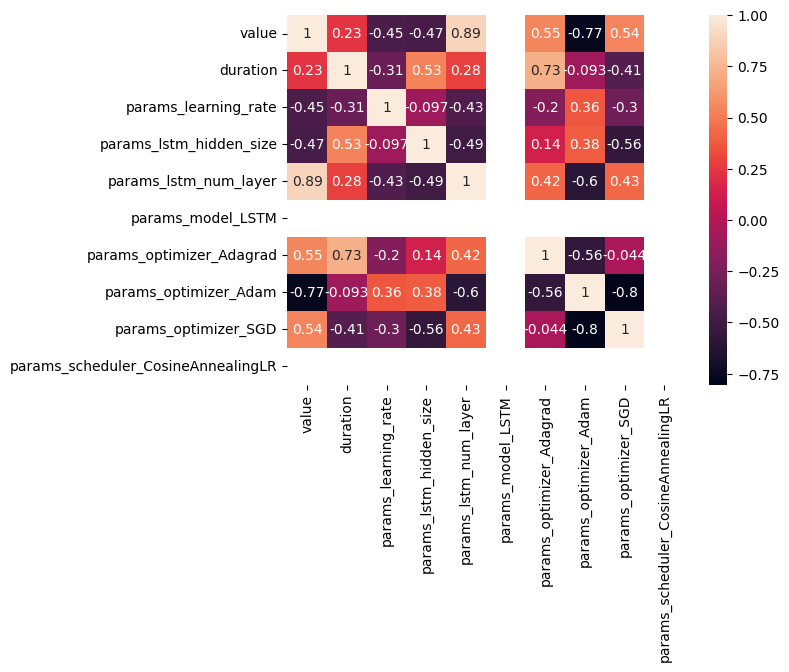

In [16]:
import seaborn as sns
sns.heatmap(pd.get_dummies(df, ['params_model', 'params_optimizer', 'params_scheduler']).corr(), annot=True)